In [106]:
import requests
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
#from tqdm import tqdm 
from sklearn import metrics  
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")

In [2]:
#jupyter nbextension enable --py widgetsnbextension
#!jupyter labextension list

# Goal

Build a text classification model on song lyrics. The task is to predict the artist from a piece of text. 

# Get the lyrics

In [3]:
#response preperation
header = {'User-agent': 'Mozilla/5.0 (X11; Linux i686; rv:2.0b10) Gecko/20100101 Firefox/4.0b10'}
#os preperation
BASEPATH = os.getcwd()
DATAPATH = f'{BASEPATH}/data/'
BASEURL = 'https://www.lyrics.com/'

artists = ('Katy-Perry','Sia')
artists = [artist.lower().replace(" ","-") for artist in artists]
###
for artist in tqdm(artists,desc="Artist"):
    Artisturl = f'{BASEURL}artist/{artist}/'
    Artistpath = f'{DATAPATH}/artist/{artist}'
    if not os.path.exists(Artistpath):
        os.makedirs(Artistpath)
    response = requests.get(Artisturl, headers=header)
    with open(f'{Artistpath}/{artist}.html', 'w') as file:
        file.write(response.text)
    time.sleep(np.random.random())  

Artist:   0%|          | 0/2 [00:00<?, ?it/s]

scrapping the artist site for links and download the lyric site

In [4]:
for artist in tqdm(artists,desc="Artists"):
    artist_data_DF = pd.DataFrame(columns=['artist', 'Album_title', 'Album_year','Song_title','Song_link','html_path','txt_path','lyric_length','txt_size'])
    Artistpath = f'{DATAPATH}/artist/{artist}'
    Artist_index_html_file = f'{Artistpath}/{artist}.html'
    with open(file=Artist_index_html_file,mode="r") as file:
        Artist_index_html_read = file.read()
    #print(Artist_index_html_read)    
    
    Artist_index_html = BeautifulSoup(markup=Artist_index_html_read,features="html.parser")
    Artist_index_main_content = Artist_index_html.find(name='div',attrs={"class":"tdata-ext"})
    for Album_entry in tqdm(Artist_index_main_content.find_all(name="div",attrs={"class":"clearfix"}),desc=f"Albums of {artist}"): # table index
        Album_info = Album_entry.find(name='h3',attrs={"class":"artist-album-label"})
        if Album_info.find(name='a'):
            Album_title = Album_info.find(name='a').get_text()
            Album_title = Album_title.replace(" ","_")
        else: Album_title = 'Unknown_Album'
        if Album_info.find(name='span',attrs={"class":"year"}):
            Album_year = Album_info.find(name='span',attrs={"class":"year"}).get_text()
            Album_year = Album_year.replace("[","")
            Album_year = Album_year.replace("]","")
        else: Album_year = '0000'
        Album_contents = Album_entry.find(name='td',attrs={'class':'tal qx'})
        for Album_content_links in Album_contents.find_all(name='a'):
            Song_title = Album_content_links.get_text()
            Song_title = Song_title.replace(" ","_")
            Song_link = Album_content_links.get('href')
            Song_link = f'{BASEURL}{Song_link}'
            
            current_entry = pd.DataFrame({'artist':artist,
                                'Album_title':Album_title,
                                'Album_year':Album_year,
                                'Song_title':Song_title,
                                'Song_link':Song_link,
                                'html_path':'',
                                'txt_path':'',
                                'lyric_length':'',
                                'txt_size':''
                               },index=[0])
            artist_data_DF = pd.concat([artist_data_DF,current_entry],axis=0,ignore_index=True)
    #artist_data_DF['html_path'] = [f"{BASEPATH}/data/artist/{artist_data_DF.loc[i, 'artist']}/html/{i}.html" for i in artist_data_DF.index]
    artist_data_DF.to_csv(f'{BASEPATH}/data/artist/{artist}/list_of_songs.csv',sep=",")

Artists:   0%|          | 0/2 [00:00<?, ?it/s]

Albums of katy-perry:   0%|          | 0/340 [00:00<?, ?it/s]

Albums of sia:   0%|          | 0/354 [00:00<?, ?it/s]

load list of songs file and download the html files

load list of songs file and extract the lyrics

In [12]:
for artist in tqdm(artists,desc="Artists"):
    Artist_data_DF_file = f'{BASEPATH}/data/artist/{artist}/list_of_songs.csv'
    txt_path_base = f'{BASEPATH}/data/artist/{artist}/txt/'
    Artist_data_DF = pd.read_csv(Artist_data_DF_file,sep=',')
    if not os.path.exists(txt_path_base):
            os.makedirs(txt_path_base)
    for index in tqdm(Artist_data_DF.index,desc=f"Songs of {artist}"):
        html_path = Artist_data_DF.loc[index, 'html_path']
        if (pd.isnull(html_path)):
            continue
        if (not os.path.exists(html_path)):
            continue
        txt_path = f'{txt_path_base}{index}.txt'
        with open(file=html_path,mode="r") as file:
            html_file = file.read()
        html_file_content = BeautifulSoup(html_file)
        lyrics = html_file_content.find('pre', id='lyric-body-text')
        if lyrics:
            with open(txt_path, 'w') as file:
                file.write(lyrics.get_text())
            Artist_data_DF.loc[index, 'txt_path'] = txt_path
            Artist_data_DF.loc[index, 'lyric_length'] = len(lyrics.get_text())
            Artist_data_DF.loc[index, 'txt_size'] = os.path.getsize(txt_path)
    Artist_data_DF.to_csv(f'{BASEPATH}/data/artist/{artist}/list_of_songs_filled.csv',sep=",",index=False)

Artists:   0%|          | 0/2 [00:00<?, ?it/s]

Songs of katy-perry:   0%|          | 0/340 [00:00<?, ?it/s]

Songs of sia:   0%|          | 0/354 [00:00<?, ?it/s]

create a corpus of songs 

In [83]:
for artist in tqdm(artists,desc="Artists"):
    Artist_data_DF_file = f'{BASEPATH}/data/artist/{artist}/list_of_songs_filled.csv'
    Artist_data_DF = pd.read_csv(Artist_data_DF_file,sep=',')
    songs = []
    for txt_file in tqdm(Artist_data_DF['txt_path'],desc=f"Processing Songs of {artist} "):
        if pd.isnull(txt_file): # continue if no file is set
            continue 
        with open(txt_file, 'r') as file:
            songs.append(file.read().replace("\n\n","\n"))
    flatten_songs = [song.replace("\n"," ") for song in songs]
    pd.DataFrame({'values':flatten_songs,'label':artist}).to_csv(f'{BASEPATH}/data/artist/{artist}/{artist}_songs.csv',sep=",",index=False)
    songlines = [line for song in songs for line in song.split("\n")]
    pd.DataFrame({'values':songlines,'label':artist}).to_csv(f'{BASEPATH}/data/artist/{artist}/{artist}_lines.csv',sep=",",index=False)

Artists:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Songs of katy-perry :   0%|          | 0/340 [00:00<?, ?it/s]

Processing Songs of sia :   0%|          | 0/354 [00:00<?, ?it/s]

get the df of the artists

In [84]:
def get_artist_songs_dfs(artist_A,artist_B):
    artist_A_df = pd.read_csv(f'{BASEPATH}/data/artist/{artist_A}/{artist_A}_songs.csv',sep=",")
    artist_B_df = pd.read_csv(f'{BASEPATH}/data/artist/{artist_B}/{artist_B}_songs.csv',sep=",")  
    return pd.concat([artist_A_df,artist_B_df],axis=0)

def get_artist_songlines_dfs(artist_A,artist_B):
    artist_A_df = pd.read_csv(f'{BASEPATH}/data/artist/{artist_A}/{artist_A}_lines.csv',sep=",")
    artist_B_df = pd.read_csv(f'{BASEPATH}/data/artist/{artist_B}/{artist_B}_lines.csv',sep=",")  
    return pd.concat([artist_A_df,artist_B_df],axis=0)

In [163]:
sia_vs_katy_song_df = get_artist_songs_dfs("sia","katy-perry")
sia_vs_katy_lines_df = get_artist_songlines_dfs("sia","katy-perry")

In [164]:
sia_vs_katy_song_df.head()

,values,label
0,"Oh, oh One foot in front of the other babe One...",sia
1,Hey I heard you were a wild one ooh If I took ...,sia
2,I'm fighting a battle I'm fighting my shadow H...,sia
3,You shout it out But I can't hear a word you s...,sia
4,"All I need is one One old man is enough Babe, ...",sia


In [165]:
sia_vs_katy_lines_df.head()

,values,label
0,"Oh, oh",sia
1,One foot in front of the other babe,sia
2,One breath leads to another yeah,sia
3,"Just keep moving, oh",sia
4,Look within for the strength today,sia


split the data frame into xtrain 

In [188]:
X,y = sia_vs_katy_lines_df.drop(['label'],axis= 1), sia_vs_katy_lines_df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)
X_train.shape ,X_test.shape,y_train.shape,y_test.shape

((23655, 1), (5914, 1), (23655,), (5914,))

In [189]:
model_TFid_NB = Pipeline([('Vectorizer', TfidfVectorizer(stop_words="english",)),
                   ('model', MultinomialNB())])
model_CountV_NB = Pipeline([('Vectorizer', CountVectorizer(stop_words="english")),
                   ('model', MultinomialNB())])
model_TFid_LR = Pipeline([('Vectorizer', TfidfVectorizer(stop_words="english")),
                   ('model', LogisticRegression())])
model_CountV_LR = Pipeline([('Vectorizer', CountVectorizer(stop_words="english")),
                   ('model', LogisticRegression(max_iter=1000))])

In [190]:
def print_evaluations(ytrue, ypred,label:str, model:str):
    
    """
    Function that compares several scores for a given model
    """
    print(f'How does model {model} score:')
    print(f'The accuracy of the model is: {round(metrics.accuracy_score(ytrue, ypred), 4)}')
    print(f'The precision of the model is: {round(metrics.precision_score(ytrue, ypred,pos_label=label), 4)}')
    print(f'The recall of the model is: {round(metrics.recall_score(ytrue, ypred,pos_label=label), 4)}')
    print(f'The f1-score of the model is: {round(metrics.f1_score(ytrue, ypred,pos_label=label), 4)}')
    metrics.ConfusionMatrixDisplay.from_predictions(ytrue, ypred);

How does model Countvectorizer and LogisticRegression on Songlines score:
The accuracy of the model is: 0.918
The precision of the model is: 0.8975
The recall of the model is: 0.963
The f1-score of the model is: 0.9291


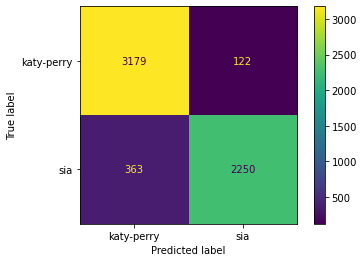

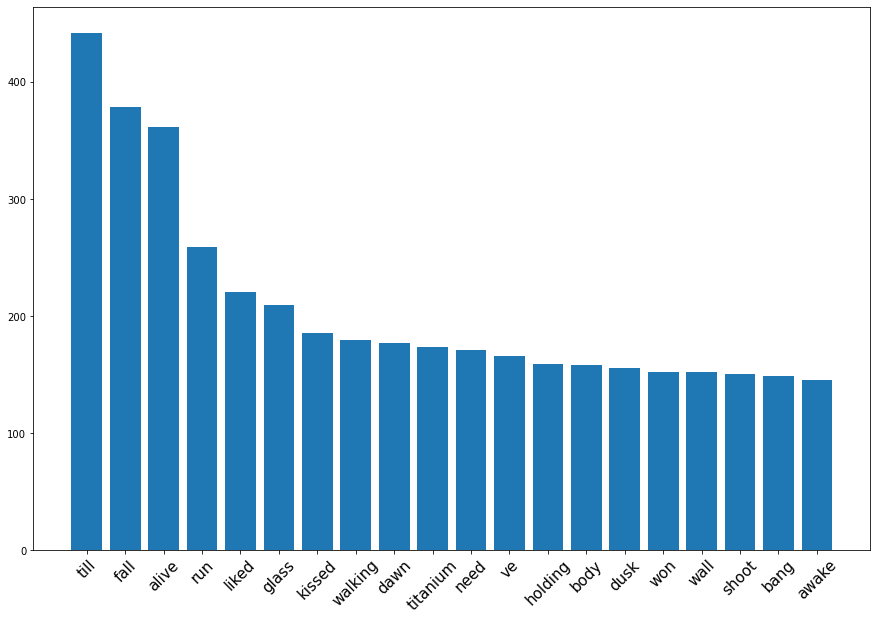

In [191]:
model_CountV_LR.fit(X_train['values'],y_train)
y_pred = model_CountV_LR.predict(X_test['values'])
model_CountV_LR.classes_[0]
print_evaluations(y_test,y_pred,model_CountV_LR.classes_[0],"Countvectorizer and LogisticRegression on Songlines")
skb = SelectKBest(f_classif, k=20)
skb_data = pd.DataFrame(model_CountV_LR[0].fit_transform(X_train['values']).toarray(),
             columns=model_CountV_LR[0].get_feature_names_out())
skb.fit(skb_data, y_train)
features = sorted(zip(skb.scores_, skb.get_feature_names_out()), reverse=True)
plt.figure(figsize=(15,10))
plt.bar(x=list(range(20)), height=sorted(skb.scores_, reverse=True)[:20])
plt.xticks(list(range(20)), [feat[1] for feat in features][:20], rotation=45, fontsize=15);

How does model TfidfVectorizer and MultinomialNB on Songlines score:
The accuracy of the model is: 0.9565
The precision of the model is: 0.9444
The recall of the model is: 0.9623
The f1-score of the model is: 0.9533


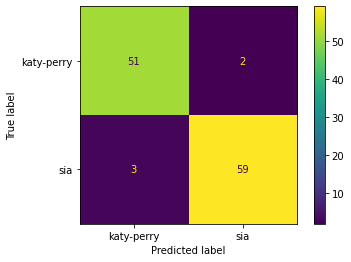

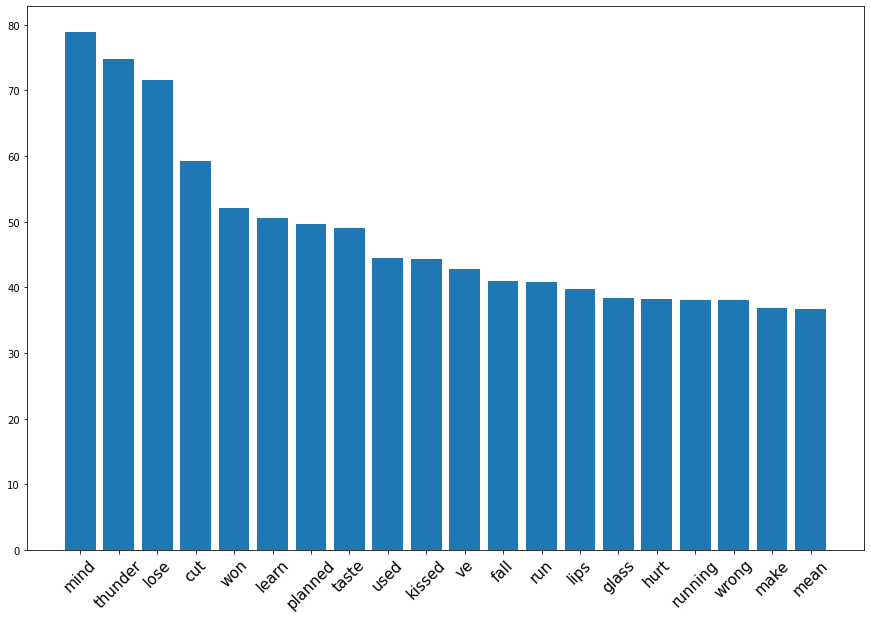

In [196]:
model_TFid_NB.fit(X_train['values'],y_train)
y_pred = model_TFid_NB.predict(X_test['values'])
model_TFid_NB.classes_[0]
print_evaluations(y_test,y_pred,model_TFid_NB.classes_[0],"TfidfVectorizer and MultinomialNB on Songlines")
skb = SelectKBest(f_classif, k=20)
skb_data = pd.DataFrame(model_TFid_NB[0].fit_transform(X_train['values']).toarray(),
             columns=model_TFid_NB[0].get_feature_names_out())
skb.fit(skb_data, y_train)
features = sorted(zip(skb.scores_, skb.get_feature_names_out()), reverse=True)
plt.figure(figsize=(15,10))
plt.bar(x=list(range(20)), height=sorted(skb.scores_, reverse=True)[:20])
plt.xticks(list(range(20)), [feat[1] for feat in features][:20], rotation=45, fontsize=15);

Now Complete Songs

In [193]:
X,y = sia_vs_katy_song_df.drop(['label'],axis= 1), sia_vs_katy_song_df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)
X_train.shape ,X_test.shape,y_train.shape,y_test.shape

((460, 1), (115, 1), (460,), (115,))

How does model Countvectorizer and LogisticRegression on Songs score:
The accuracy of the model is: 0.9391
The precision of the model is: 0.9259
The recall of the model is: 0.9434
The f1-score of the model is: 0.9346


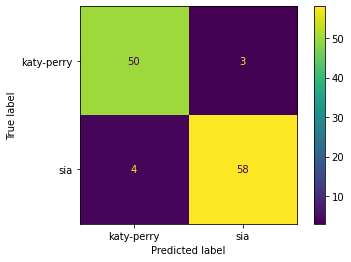

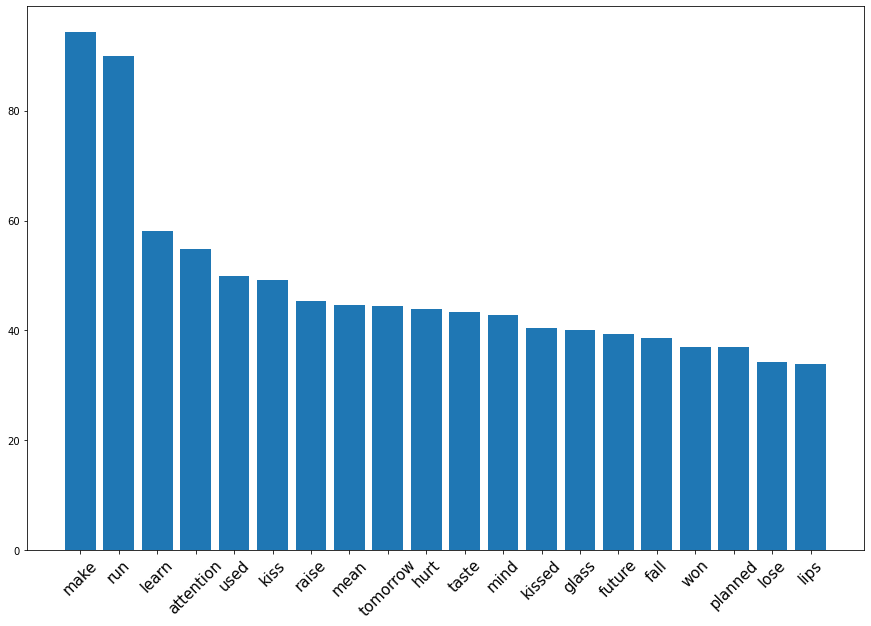

In [194]:
model_CountV_LR.fit(X_train['values'],y_train)
y_pred = model_CountV_LR.predict(X_test['values'])
model_CountV_LR.classes_[0]
print_evaluations(y_test,y_pred,model_CountV_LR.classes_[0],"Countvectorizer and LogisticRegression on Songs")
skb = SelectKBest(f_classif, k=20)
skb_data = pd.DataFrame(model_CountV_LR[0].fit_transform(X_train['values']).toarray(),
             columns=model_CountV_LR[0].get_feature_names_out())
skb.fit(skb_data, y_train)
features = sorted(zip(skb.scores_, skb.get_feature_names_out()), reverse=True)
plt.figure(figsize=(15,10))
plt.bar(x=list(range(20)), height=sorted(skb.scores_, reverse=True)[:20])
plt.xticks(list(range(20)), [feat[1] for feat in features][:20], rotation=45, fontsize=15);

How does model TfidfVectorizer and MultinomialNB on Songs score:
The accuracy of the model is: 0.9565
The precision of the model is: 0.9444
The recall of the model is: 0.9623
The f1-score of the model is: 0.9533


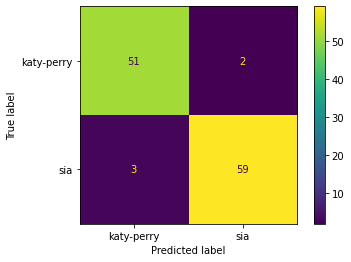

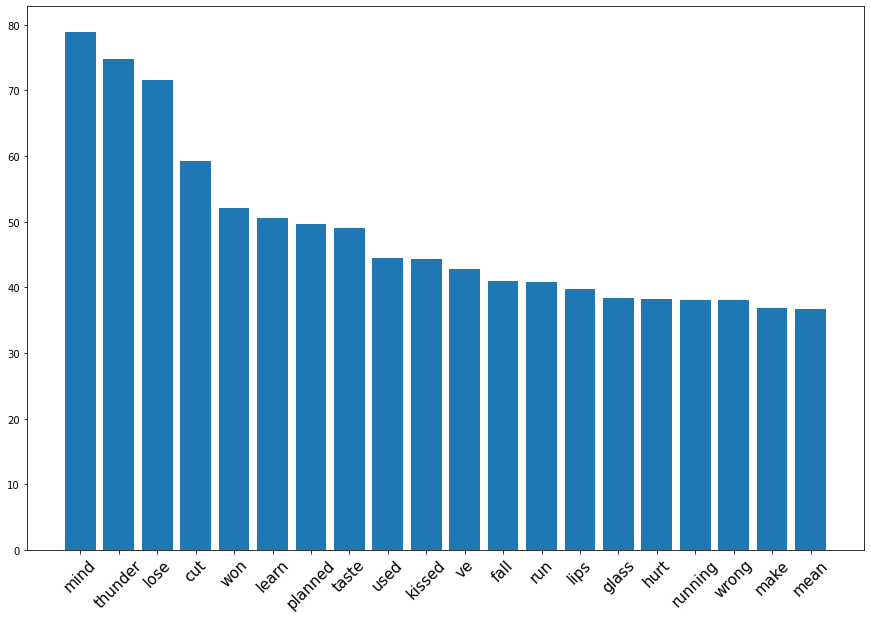

In [187]:
model_TFid_NB.fit(X_train['values'],y_train)
y_pred = model_TFid_NB.predict(X_test['values'])
model_TFid_NB.classes_[0]
print_evaluations(y_test,y_pred,model_TFid_NB.classes_[0],"TfidfVectorizer and MultinomialNB on Songs")
skb = SelectKBest(f_classif, k=20)
skb_data = pd.DataFrame(model_TFid_NB[0].fit_transform(X_train['values']).toarray(),
             columns=model_TFid_NB[0].get_feature_names_out())
skb.fit(skb_data, y_train)
features = sorted(zip(skb.scores_, skb.get_feature_names_out()), reverse=True)
plt.figure(figsize=(15,10))
plt.bar(x=list(range(20)), height=sorted(skb.scores_, reverse=True)[:20])
plt.xticks(list(range(20)), [feat[1] for feat in features][:20], rotation=45, fontsize=15);